# Predicting Property Values and Appeals

This project builds on earlier work that used statistical inference to analyze the relationship between property data, property value and assessement appeals. This project will focus on using machine learning technique to train models optimized to offering the best predictions against unseen data.

## Problem statement

The Cook County Assessor's Office (CCAO) is concerned about faily assessing property values in Cook County, which has implications on taxpayers. Additionally, because appeals have become a foregone step in the assessment procedure, the CCAO is concerned about the prospect of a regressive tax, and would like to anticipate appeals. The objective of this project is to fairly assess property values, and additionally predict whether a taxpayer will appeal the first-pass assessed value on their property

The CCAO has faced numerous issues with fairly and accurately assessing property values, as detailed by ProPublica. The CCAO has recently made an effort to be more transparent, and have published their models and pipelines on Github for public critique. The current CCAO uses linear regression models implemented in R. This project will utilze machine learning techniques in Python.

Predicting property values and appeals are supervised learning problems, and in this case the models will be trained using offline data. Predicting property values will be modeled using a regression setting, the performance measured with R^2 coefficient of determination. The CCAO may prefer an asymmetrical metric that underestimates property values, so as to not over-tax low-income property owners. Therefore, a preferable metric is an asymmetrical one that penalizes overestimation more than underestimation. (This will be a reach goal in this project.) At a minimum, a model that has an R-Square of 66% will be enough.

Predicting appeals will be a supervised learning problem, using a model trained using the same offline data using a classification setting. The performance for the model will be measured by recall score. The CCAO would like to identify properties that will be appealed. We would like to identify at least 50% of true appeals with a precision of at least 20% -- that is, half of appeals will be identified, and 20% of those properties are actually appealed. The f1 score will also be monitored.

This project will leverage the  Yellowbrick library, a model diagnostic visualization library by Bengfort and Bilbro. Yellowbrick will help to evaluate the performance of machine learning models and diagnosing problems.

In [1]:
%matplotlib inline

In [2]:
!pip install --upgrade yellowbrick

  Obtaining dependency information for yellowbrick from https://files.pythonhosted.org/packages/06/35/c7d44bb541c06bc41b3239b27af79ea0ecc7dbb156ee1335576f99c58b91/yellowbrick-1.5-py3-none-any.whl.metadata
Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)


In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import parallel_backend


In [4]:
!pip install --upgrade imblearn

  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)


In [5]:
!pip install -U scikit_learn

  Obtaining dependency information for scikit_learn from https://files.pythonhosted.org/packages/79/3d/02d5d3ed359498fec3abdf65407d3c07e3b8765af17464969055aaec5171/scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 330.3 kB/s eta 0:00:33
   ---------------------------------------- 0.1/10.6 MB 751.6 kB/s eta 0:00:14
    --------------------------------------- 0.2/10.6 MB 1.2 MB/s eta 0:00:09
   - -------------------------------------- 0.4/10.6 MB 1.9 MB/s eta 0:00:06
   -- ------------------------------------- 0.6/10.6 MB 2.5 MB/s eta 0:00:04
   ---- ----------------------------------- 1.1/10.6 MB 3.8 MB/s eta 0:00:03
   ------- -------------------------------- 2.0/10.6 MB 5.7 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/10.6 MB 6.2 MB/s eta 0:00:02
   ------------- -----

In [6]:
!pip install -U imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/6e/1b/66764ecf370e797759be06fb38c11640ea1f9456ae10f8640a33cfa726ea/imbalanced_learn-0.12.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   --- ----------------------------------- 20.5/258.0 kB 330.3 kB/s eta 0:00:01
   ------ -------------------------------- 41.0/258.0 kB 330.3 kB/s eta 0:00:01
   --------------- ---------------------- 102.4/258.0 kB 658.3 kB/s eta 0:00:01
   ---------------------------------- ----- 225.3/258.0 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 258.0/258.0 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [7]:
!pip3 install imblearn --ignore-installed scikit-learn

  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/79/3d/02d5d3ed359498fec3abdf65407d3c07e3b8765af17464969055aaec5171/scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/6e/1b/66764ecf370e797759be06fb38c11640ea1f9456ae10f8640a33cfa726ea/imbalanced_learn-0.12.2-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.12.2-py3-none-any.whl.metadata (8.2 kB)
  Obtaining dependency information for numpy>=1.19.5 from https://files.pythonhosted.org/packages/3f/6b/5610004206cf7f8e7ad91c5a85a8c71b2f2f

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'd:\\anaconda3\\Lib\\site-packages\\numpy\\core\\_multiarray_tests.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [8]:
import imblearn

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
from imblearn.pipeline import Pipeline as ImbalancePipeline


In [11]:

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.svm import LinearSVC, SVC


In [12]:

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold
from yellowbrick.contrib.missing import MissingValuesDispersion, MissingValuesBar
from yellowbrick.features import Rank1D, Rank2D
from yellowbrick.regressor import AlphaSelection, ManualAlphaSelection, ResidualsPlot
from yellowbrick.target import ClassBalance, FeatureCorrelation


In [14]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 120)

N_JOBS = 16

## Data description

To predict property values and appeals, our model will need to know about property characteristics and geo-spatial data. For predicting appeals, data about how the property has been assessed and the socio-economic makeup of the neighborhood to infer information about the property owner.

Cook County has 1.8 million parcels, and a sample of 2% of those parcels may be enough information to create a predictive model for property value. The CCAO, with ProPublica and the University of Chicago, have provided a dataset with 47,000 samples and 100 features aggregated from many sources. 

The dataset is available on Coursera, and will be loaded onto a local workspace and Google Colab for analysis. The dataset is not-for-distribution and should be kept secured (read: not uploaded to Github). The dataset itself contains some semi-sensitive data, including addresses for the property and taxpayers, but the dataset does not contain any PII. The sensitive data will be immediately dropped so it's not included in analysis, but the file itself will not be re-saved without the sensitive data.

The dataset is a CSV format file, and comes with a semi-informative data dictionary. The file is 26.5 MB, and portable enough that it does not need to be compressed to another format. The file contains records of properties, and related data, such as property attributes, geographical data, information about the taxpayer, the sale, Census data, and other data aggregated from third-party data providers. A data dictionary is provided below, as well as an explanation of what data will be used for analysis and how it will be used.

In [18]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 20CF-C746

 Directory of c:\Users\onayr\OneDrive\Private\JobSearch\GitHub\on-ai\Marketing-House-Predictions\notebooks

04/10/2024  08:13 AM    <DIR>          .
04/09/2024  11:21 AM    <DIR>          ..
04/10/2024  09:28 AM         1,082,020 ChicagoHouseAssessments.ipynb
04/09/2024  02:54 PM         1,273,265 PropertyTaxAppeals.ipynb
               2 File(s)      2,355,285 bytes
               2 Dir(s)  849,916,231,680 bytes free


In [15]:
datadict_df = pd.read_csv('./data/project3datadict.csv', encoding='ISO-8859-1')
datadict_df.head(120).style.hide_index()

FileNotFoundError: [Errno 2] No such file or directory: './data/project3datadict.csv'

We find that this dataset is very well curated. It offers an exhaustive qualitative and quantitative description of the property, its attributes and amenities, and includes data aggregated from third-party sources, such as the Census, Greatschools, Walkscore, and Yelp.

* Property classification, including the residential class, whether the property is single- or multi-use, a condominium. The architectural and design plan types of the property. Whether the property is homeowner-occupied and is exempt from taxes. These variables are categorical and included in analysis, although there is no information about the values of the variables.

* Property attributes, such as the number of beds, bathrooms, the property size, and an exhaustive amount of features about the quality of the construction, roofing, basement, garage, fireplaces, etc. These variables are numeric and categorical, and the categorical variables are encoded. These variables are used in analysis.

* Geospatial information about the property, including its address, community, latitude and longitude, and other neighborhood blocks. The only geospatial information that is used in analysis is the Chicago community area.
Census tract information related to where the property is located, including economic data, such as the poverty level and median household income, and demographics, such as the racial makeup of the tract and the total population. This data is included in modeling.

* Site desirability and amenity variables from third-part aggregators, such as Walkscore, Yelp! reviews and Great Schools. All the provided variables are used in modeling. The variables are numeric, and only a few Yelp! variables needed to be cured.

* Sale data, such as the tax year, taxes paid, the first-pass assessed value, sale price, and percentile. This data is removed from the sale valuation modeling, as it constitutes data leaking to the model. Similarly, lawyer constitutes data leaking for the appeals process.

* Taxpayer information, such as the taxpayer's contact information, and whether they live in-state. This informaiton is not considered relevant to the analysis, but in_state is used as it may influence the appeals process.
Property identification and metadata, such as the PIN numbers, and other identifiers to map the data to other datasets, such as Census tracts and Chicago community areas. There is other metadata that is marked as "unused" in the data dictionary, or included for ETL purposes, such as geo_merge. This information is excluded from analysis.

It's clear that great effort was spent in collecting and preparing the dataset. It is assumed that many features have already been engineered, and the dataset is ready for modeling. The dataset will not be thoroughly inspected, but will be checked for errors and scaled for modeling.

In [17]:
# review from data dict
df = pd.read_csv('./data/project3data.csv')

y_appeal = 'appeal_flag'
y_value = 'value'

categorical_cols = [
    'ac',
    'attic',
    'atticfin',
    'basement',
    'basementfin',
    'centralheat',
    'class',
    'community',
    'condo',
    'designtype',
    'garageattached',
    'garageattached2',
    'garageconstruction',
    'garageconstruction2',
    'homeowner',
    'in_state',
    'major_class',
    'otherheat',
    'plantype',
    'porch',
    'quality',
    'repair',
    'rnv',
    'roof',
    'taxyear',
    'tri',
    'type',
    'use',
    'walkfac',
    'walls',
]

numeric_cols = [
    'age',
    'apts',
    'asian',
    'avg_school_score',
    'beds',
    'black',
    'college',
    'dist_med',
    'dist_med_lessthan1k',
    'elem_score',
    'fb',
    'fireplaces',
    'garagearea',
    'garagearea2',
    'garagesize',
    'hb',
    'hdsf',
    'high_school_score',
    'hispanic',
    'medhinc',
    'nativ',
    'numreviews_med_lessthan1km',
    'numreviews_med',
    'numreviews_med_5',
    'poverty',
    'rating_med',
    'rating_med_5',
    'rooms',
    'site',
    'squarefoot',
    'totalpop',
    'two',
    'vol',
    'walkscore',
    'white',
]

appeal_cols = [
    'av1',
    'percentile',
    'taxes',
    'value',
]

FileNotFoundError: [Errno 2] No such file or directory: './data/project3data.csv'


## Data exploration

We will study the data attributes and their characteristics. We have seen a lot of this same data in previous modules, so we won't do an exhaustive review. There are a significant amount of new data, but the data dictionary is poorly documented for those new features (e.g., garage-related variables).

Data has already been separated to categorical and numeric features. We examine continuous and categorical variables for missing data and outliers, in order to understand how it should be adjusted. This dataset does not contain much text -- there are street addresses, and names for lawyers, but these data will not be analyzed. 

Features that are used for modeling appeals are separated because they otherwise would leak data to a property valuation model.


In [37]:
df.shape

(47001, 100)

### Missing values

In [38]:
df_ = df[categorical_cols]
df_ = df_[df_.dtypes[(df.dtypes == 'float64') | (df_.dtypes == 'int64')].index]

visualizer = MissingValuesDispersion(features=df_.columns, size=(750, 500))
visualizer.fit(df_.values)
visualizer.show();

NameError: name 'MissingValuesDispersion' is not defined

No handles with labels found to put in legend.


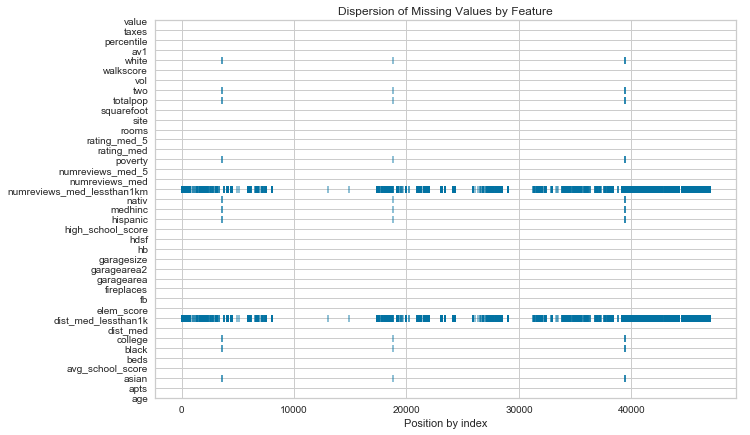

In [9]:
visualizer = MissingValuesDispersion(features=numeric_cols + appeal_cols, size=(750, 500))
visualizer.fit(df[numeric_cols].values)
visualizer.show();

We find missing data related to Yelp reviews, specifically reviews for establishments less than 1 kilometer from a property.

In [10]:
df[['numreviews_med', 'numreviews_med_5', 'numreviews_med_lessthan1km', 'dist_med', 'dist_med_lessthan1k']].head()

,numreviews_med,numreviews_med_5,numreviews_med_lessthan1km,dist_med,dist_med_lessthan1k
0,352.5,150,NaN,1511.060579,NaN
1,321.5,148,149.0,1511.060579,338.698698
2,321.5,150,NaN,1511.060579,NaN
3,353.0,150,140.0,1511.060579,911.562546
4,112.5,80,105.0,1511.060579,793.536029


In [11]:
df[df['numreviews_med_lessthan1km'] == 0][['numreviews_med', 'numreviews_med_5', 'numreviews_med_lessthan1km', 'dist_med', 'dist_med_lessthan1k']].head()

,numreviews_med,numreviews_med_5,numreviews_med_lessthan1km,dist_med,dist_med_lessthan1k


In [12]:
df[df['dist_med_lessthan1k'] == 0][['numreviews_med', 'numreviews_med_5', 'numreviews_med_lessthan1km', 'dist_med', 'dist_med_lessthan1k']].head()

,numreviews_med,numreviews_med_5,numreviews_med_lessthan1km,dist_med,dist_med_lessthan1k


There are no zero values. We assume that when there are no establishments reviewed on yelp within 1lk of the property, this value is NaN instead of 0. However, we can't impute the number to zeor, because that's not correct. Instead, this is a signal of a property without yelp-reviewed establishments nearby, perhaps in a rural or industrial location. We'll impute the value as zero, but create a new variable, so that we can analyze this variable as a numeric.

There is also sporadic missing data related to Census tract data. There aren't many records (6 rows). There is no viable way to impute this data, but due to the small size of these errors, we will drop it.


In [13]:
df[df['white'].isna()].shape

(6, 100)

There are also missing values for the assessed value feature, and the distribution of the feature looks riddled with errors, as there are negatively-valued assessments. These should be removed.

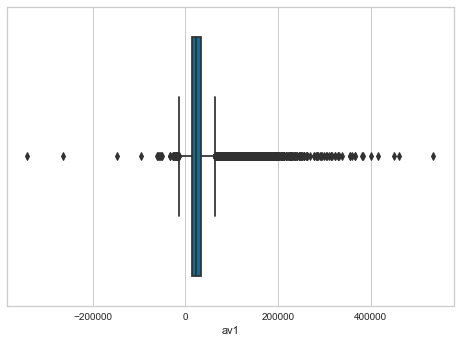

In [14]:
sns.boxplot(df['av1']);

### Continuous variables

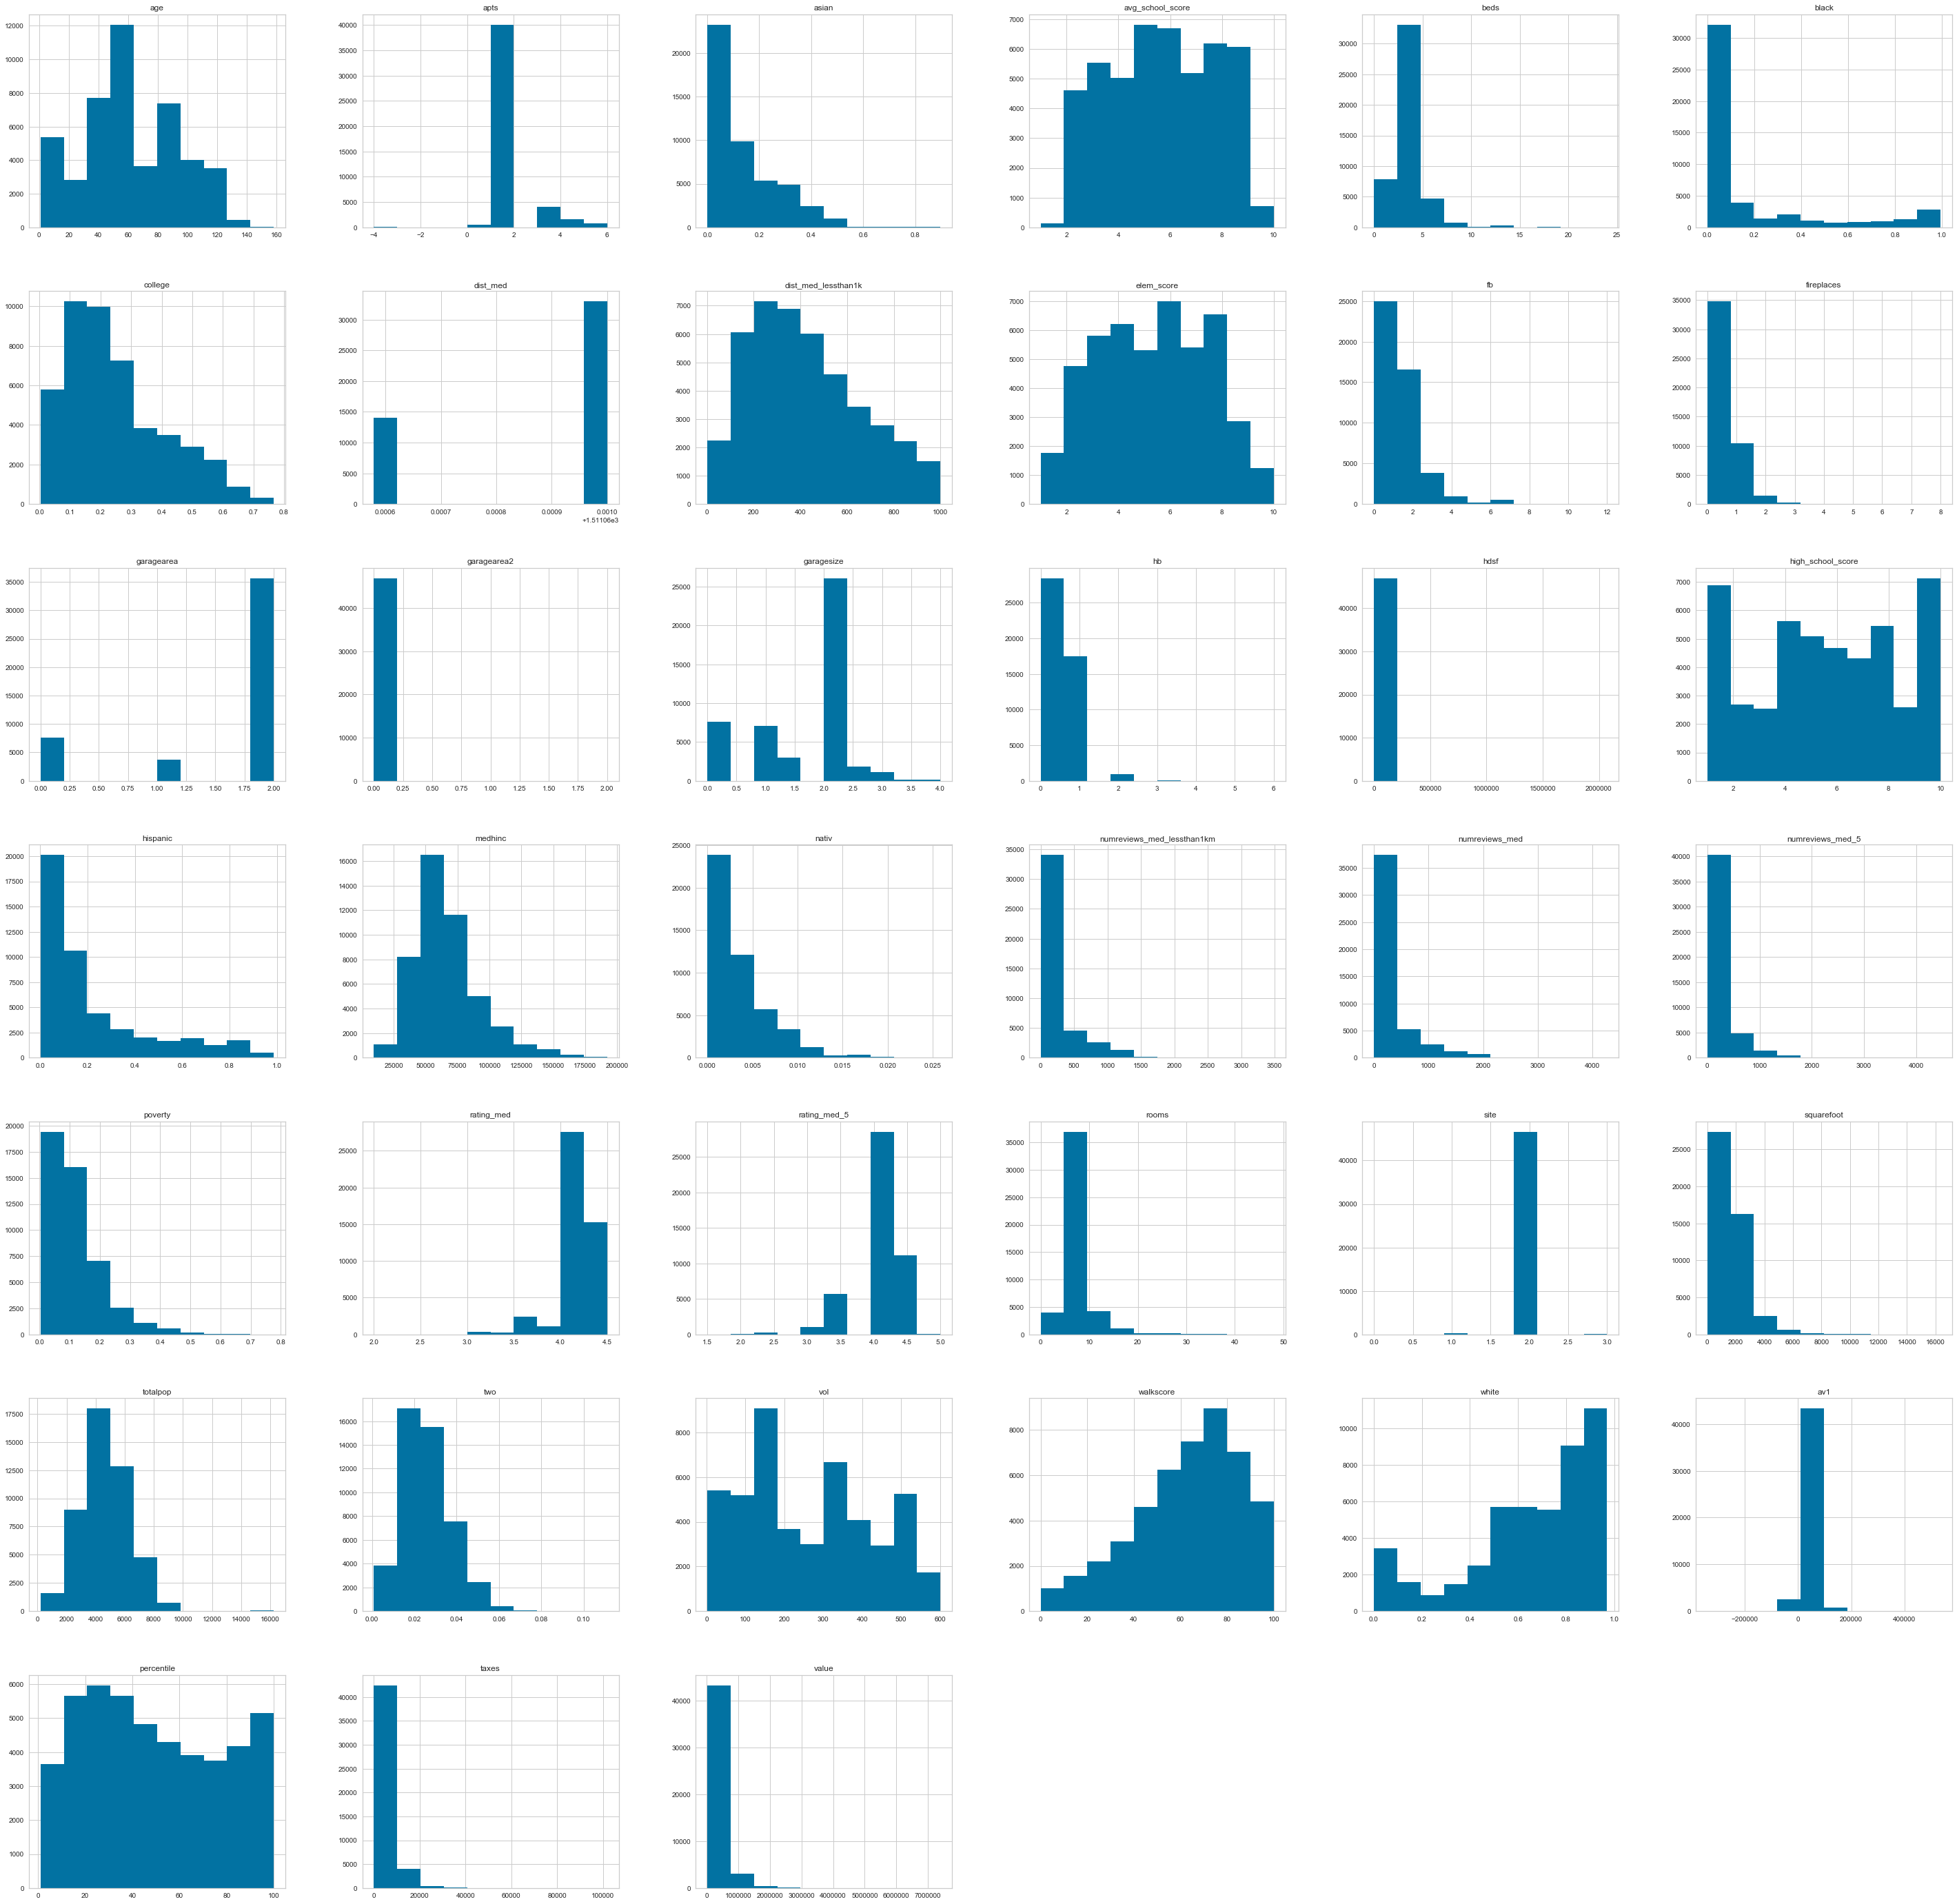

In [15]:
df.hist(column=numeric_cols + appeal_cols, figsize=(50, 50));

We note that there are some variables that should be scaled, such as variables that represent large-scale numbers and have a natural skew, such as square footage, sale value and medium household income.

#### Feature normality

We use the Shapiro-Walk ranking to get an assessment of how normal each continuous variable is.

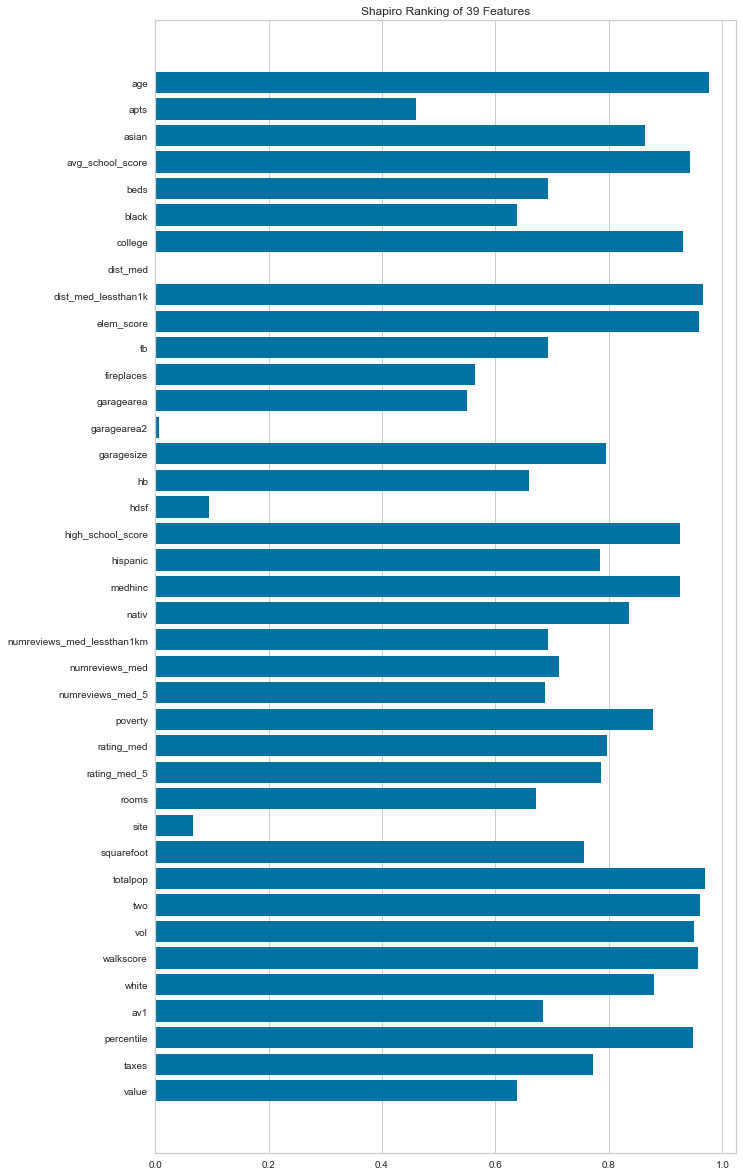

In [16]:
X = df[numeric_cols + appeal_cols].fillna(0)
y = df[y_value]

visualizer = Rank1D(algorithm='shapiro', size=(750, 1500))
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show();

Almost all variables seem to be normal, except for two variables which may be derivatives of either values (e.g., `garagearea2` may be a squared-value of `garagaearea`).

#### Feature correlation

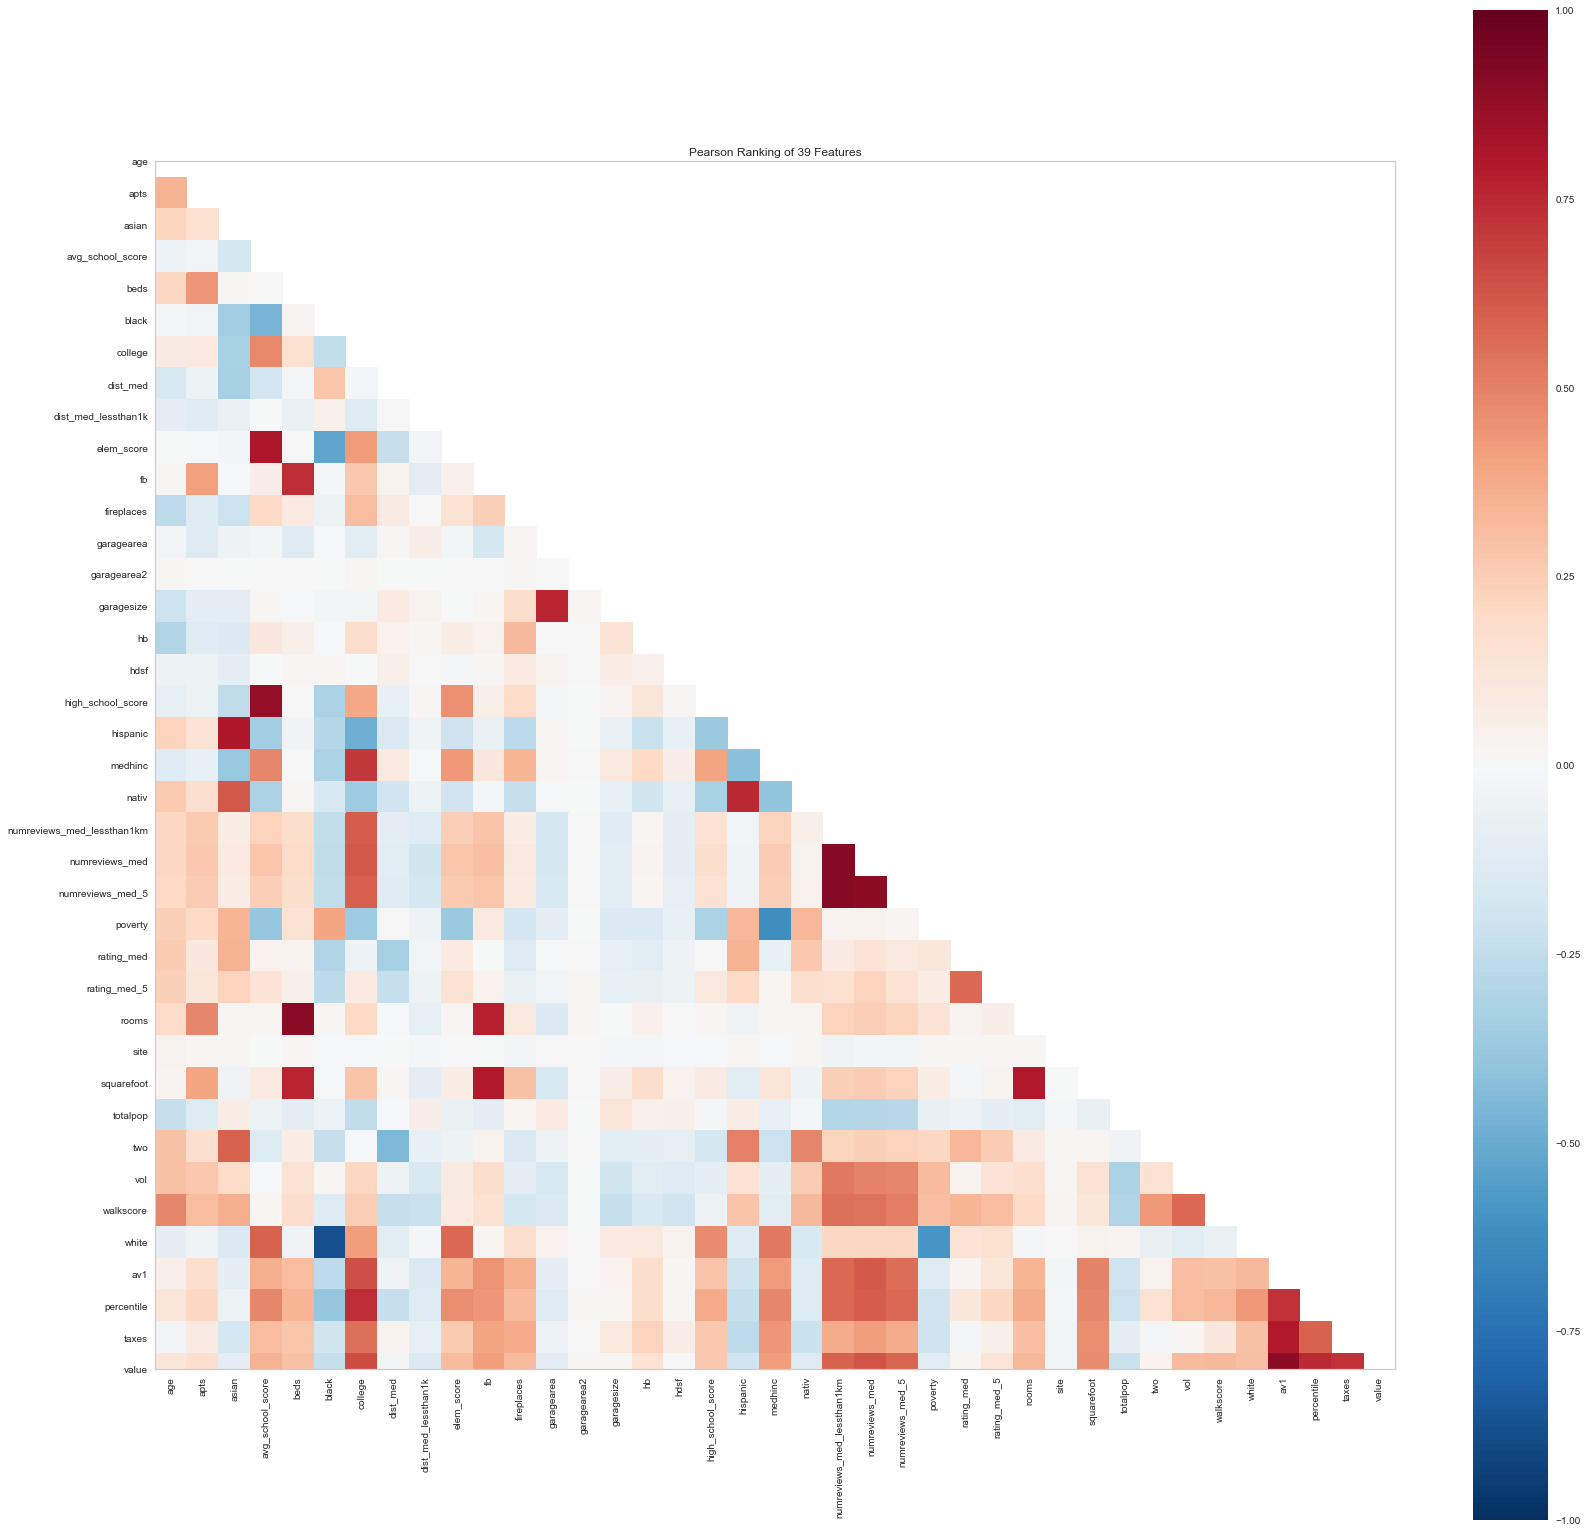

In [17]:
visualizer = Rank2D(algorithm='pearson', size=(2000, 2000))
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show();

There are a lot of features, and there is some multicolinearity that occurs with related variables, such as garage area and derivative variables, or Yelp reviews and derivative variables. We do not have many tools at the moment to handle these similar variables (e.g., principal components analysis). To handle the multicolinear data, we can pain-stakingly understand each variable, or we can try non-linear models.

### Categorical variables

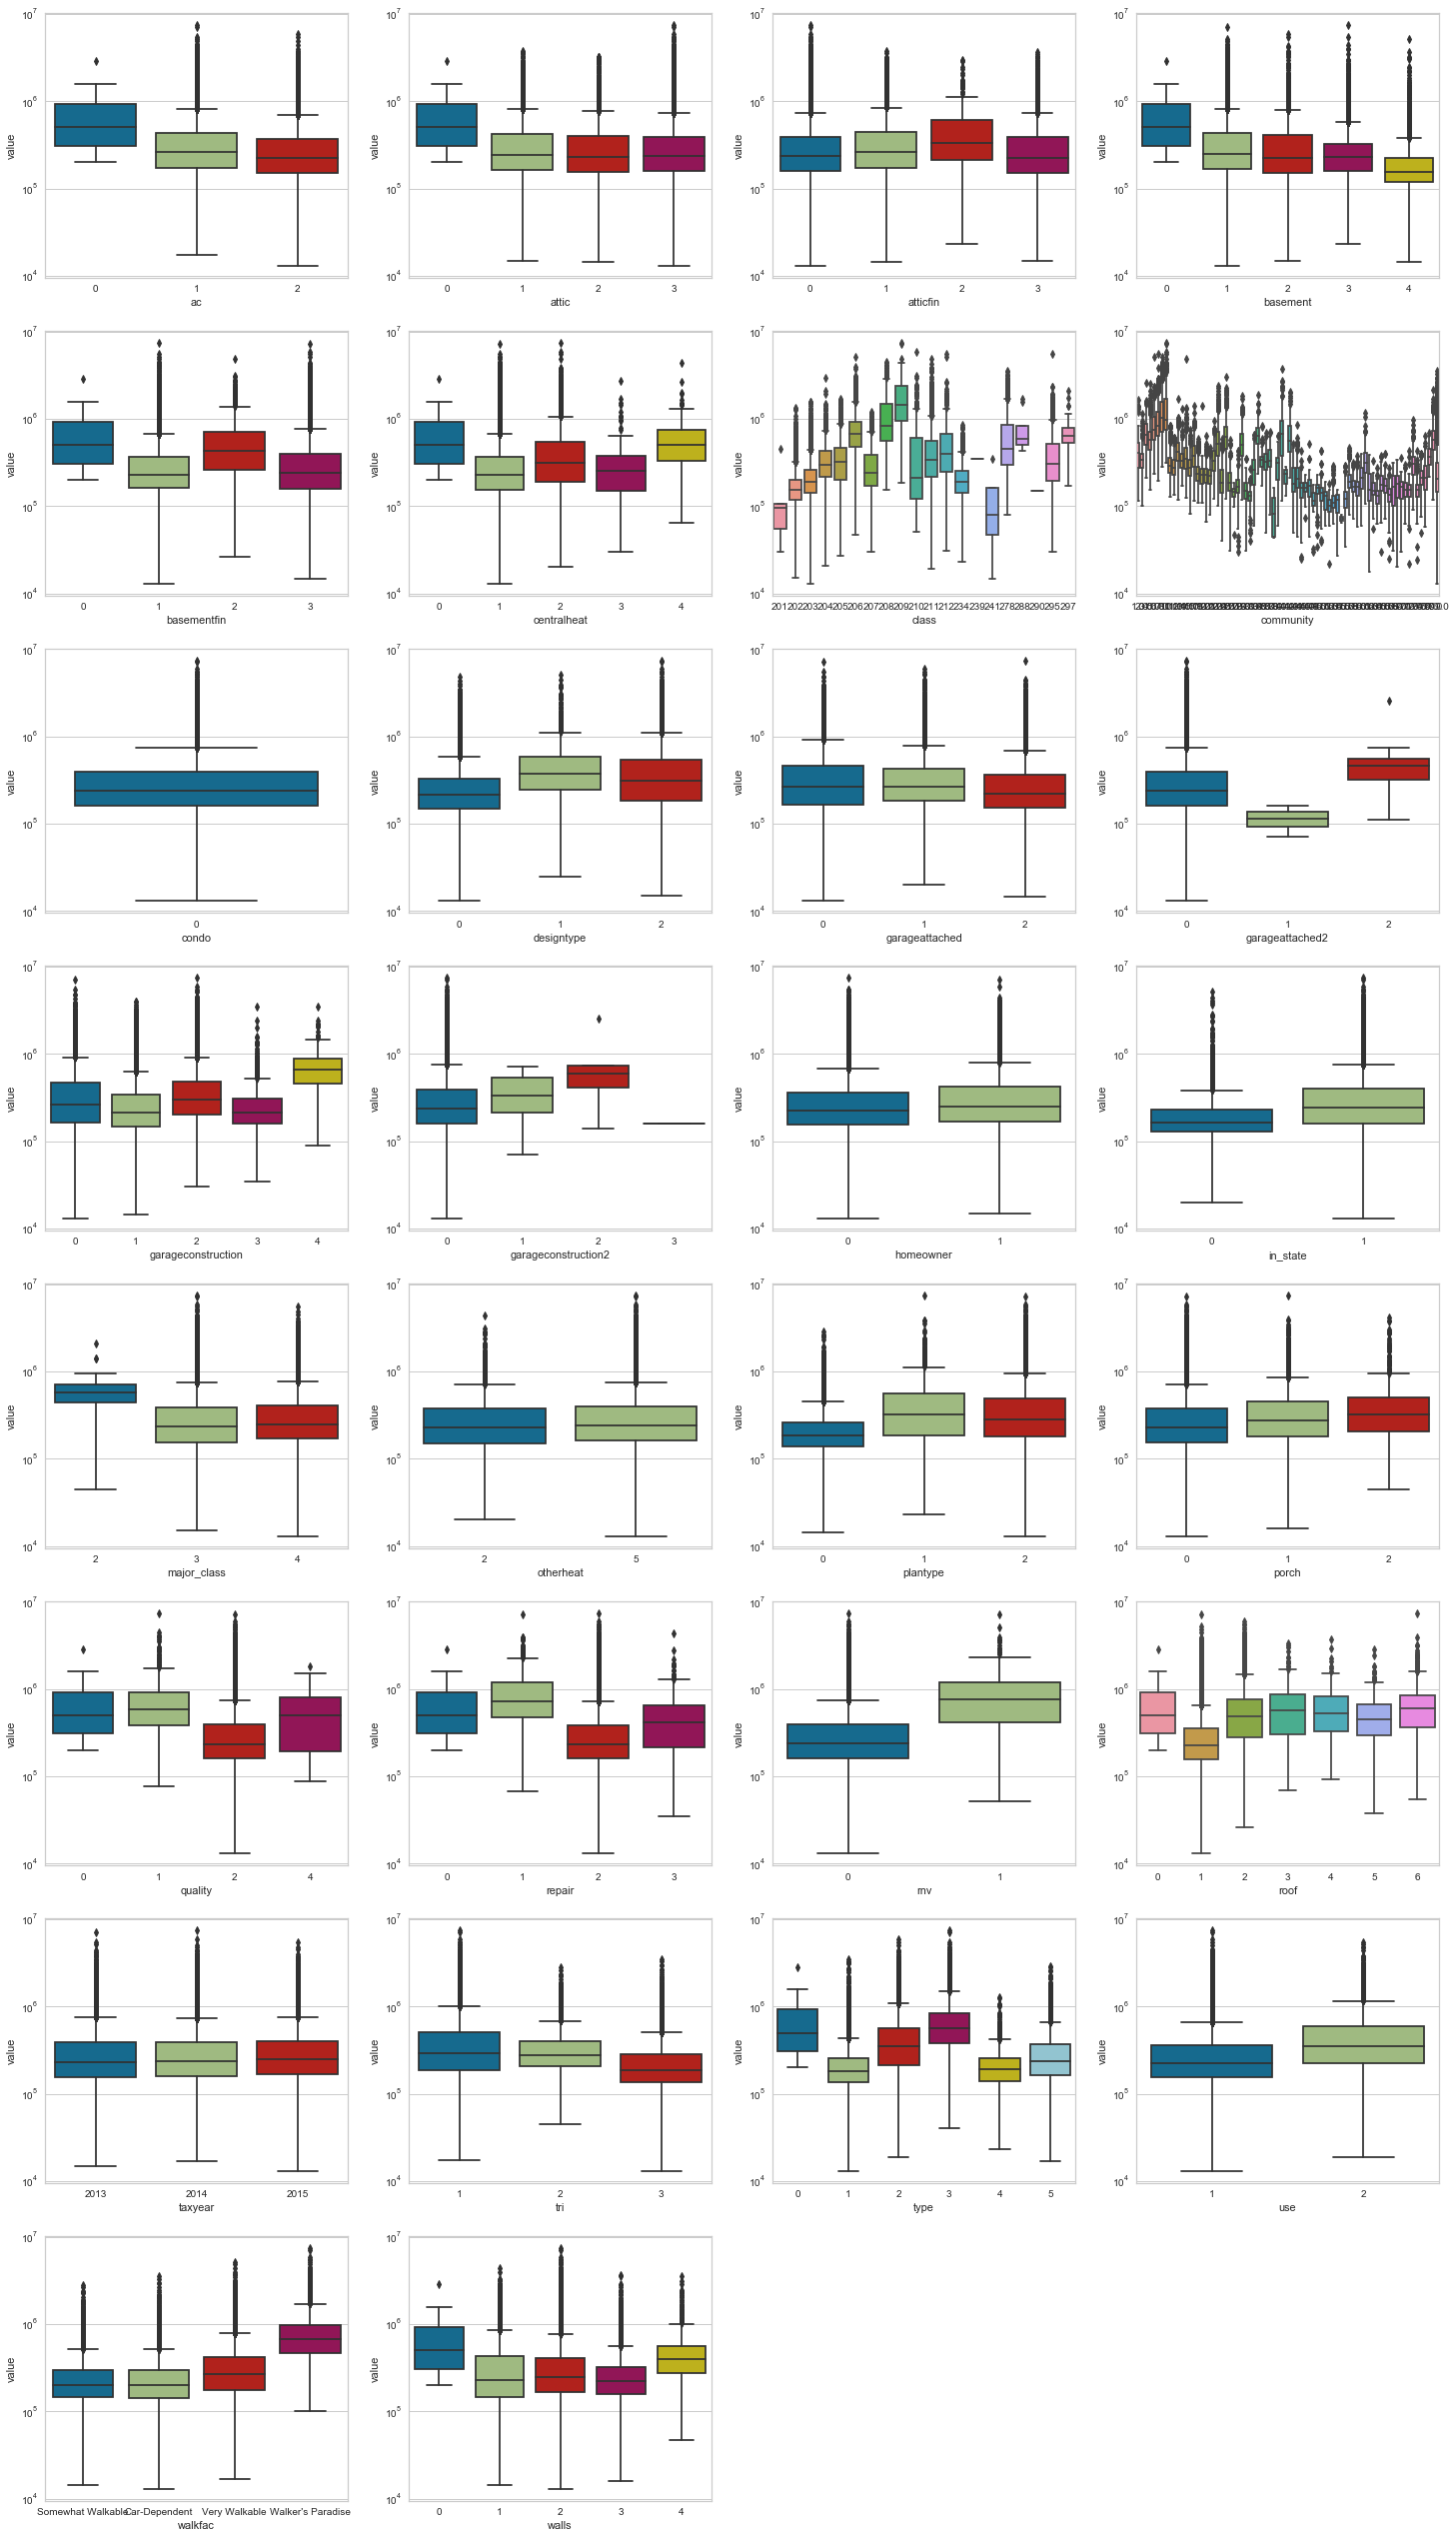

In [18]:
plt.figure(figsize=(25, 75))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(13, 4, i) 
    g = sns.boxplot(x=df[col], y=df[y_value])
    g.set(yscale='log')

Many of these categorical variables do not have an appreciable amount of detail in the data dictionary, and it's not simple to deduce what they mean. There are many related variables, such as `basement` and `basementfin`, and there is no coursery pattern among variables like these.

We look at a new variable that lists a lawyer that helped a taxpayer appeal their assessment.

In [19]:
lawyer = (~df['lawyer'].isna()).astype(int)
pd.crosstab(lawyer, df['appeal_flag'])

appeal_flag,0,1
lawyer,,
0,42104,18
1,0,4879


Whether someone has a lawyer is entirely predictive of whether someone will appeal. In fact, if someone appeals, 99.63% of the time, they have a lawyer. This aligns with the idea that the CCAO appeals process has a legal cottage industry around it. Because we're predicting whether someone will appeal, we have to look at how their property is assessed and features of their property. We will drop the lawyer feature because it will leak data into an appeals model.

### Target variables

As our modeling problem involves a supervised model, we must identify target variables to compare against  model predictions. For our analysis, the sale value of the property will be the target variable of the valuation model and the appeal flag will be the target variable for the appeals model.

We examine what other features are correlated with the target variable value.

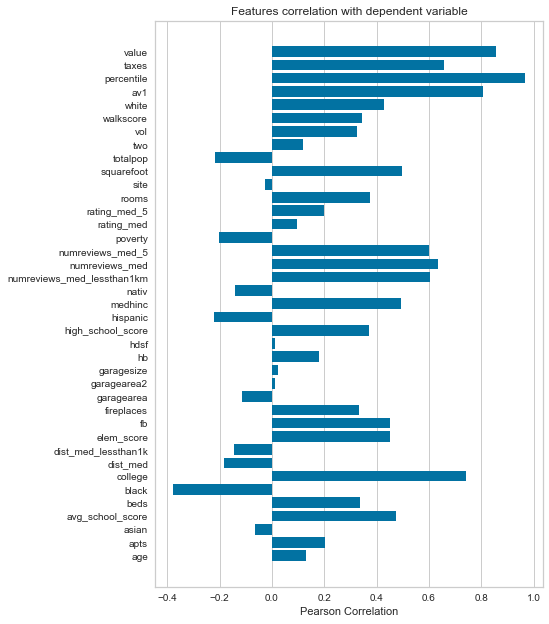

In [20]:
X = df[numeric_cols + appeal_cols]
X_numeric = X[X.dtypes[(X.dtypes == 'float64') | (X.dtypes == 'int64')].index].fillna(0)

visualizer = FeatureCorrelation(labels=X_numeric.columns, size=(500, 750))
visualizer.fit(X_numeric, np.log(y))
visualizer.show();

There is strong correlation with the assessed value and percentile. Both these values are inherently related to the sale value. In order to avoid data leakage, these values are hidden from the valuation model. They will only be available to the appeals model. That is why the feature names are organized with different lists.

## Data Preparation
Following the review of the data, we will clean the data by revising missing data and outliers, and adjust and engineer features.

### Data cleaning

Impute missing values related to Yelp review features:

In [21]:
df['noyelpreviews_lessthan1k'] = df['dist_med_lessthan1k'].isna().astype(int)
df['numreviews_med_lessthan1km'] = df['numreviews_med_lessthan1km'].fillna(0)
df['dist_med_lessthan1k'] = df['dist_med_lessthan1k'].fillna(0)

Drop records with missing Census tract values:

In [22]:
df = df[~df['white'].isna()]

Drop missing and negatively-valued first pass assessed valuation outliers:

In [23]:
df = df[df['av1'] > 0]

Ensure our remaining dataset does not have missing data:

In [24]:
df[df.columns[df.isnull().sum() > 0]].isnull().sum()

spmap_community_id    24729
pnum                  1    
pdir                  17942
pstreet               1    
psuf                  291  
pcity                 1    
pstate                1    
lawyer                41996
dtype: int64

We are not using any of these features. They will be dropped from the dataframe so that we can safely ensure our dataset doesn't have missing data.

In [25]:
df = df.drop(columns=['spmap_community_id', 'pnum', 'pdir', 'pstreet', 'psuf', 'pcity', 'pstate', 'lawyer'], axis=1)

In [26]:
df[df.columns[df.isnull().sum() > 0]].isnull().sum()

Series([], dtype: float64)

### Feature engineering

Log-scale transformation of features with skewed, large-valued numbers, such as square footage, sale value and medium household income:

In [27]:
df['medhinc'] = np.log(df['medhinc'] + 1)
df['hdsf'] = np.log(df['hdsf'] + 1)
df['squarefoot'] = np.log(df['squarefoot'] + 1)
df['av1'] = np.log(df['av1'] + 1)
df['taxes'] = np.log(df['taxes'] + 1)
df['value'] = np.log(df['value'] + 1)

Features that can be combined:

In [28]:
df['baths'] = df['fb'] + 2 * df['hb']
numeric_cols += ['baths']
numeric_cols.remove('fb')
numeric_cols.remove('hb')

In a previous project, we found two formulas suggested by Robert Ross in the study "The impact of Property Tax Appeals on Vertical Equity in Cook Country." We will include those variables here, because they were important in inferring what properties were appealed.

The assessment ratio of a property is "the ratio of the CCAO estimate of that property’s market value to the actual sale price of the property, in the year the property sold." This value tends to be at around 0.10, which matches the "2019 Cook County Tax Rates Released" report by Cook County Clerk Real Estate and Tax Service. We notice that the value is actually lower than 0.10, which matches the assessent of the CCAO CTO that the assessed valuation model deployed by the previous administration undervalued properties.

The effective tax rate on housing wealth is "the ratio of taxes paid in the year a property sold to the sale price of that property, in the year the property sold." Ross also notes that if effective tax rates are strongly negatively correlated with home values, he claims it is evidence of regressive property taxes. Below, we plot the effective tax rate against the sale value of the property and note that the lower the value, the higher the effective tax rate. This suggests that, in fact, property taxes are regressive in Chicago. The appeals process may be making taxes more regressive - we will analyze this later.

In [29]:
df['assessment_ratio'] = df['av1'] / df['value']
df['effective_tax_rate'] = df['taxes'] / df['value']
appeal_cols += ['assessment_ratio', 'effective_tax_rate']

### Feature selection

At first, all numeric and categorical variables (that don't directly cause a data leak) will be used in modeling. There are 100 features with scant documentation. The first approach will throw everything into the model, and rely on regularization to adjust and select features. A more nuanced approach at selecting features and determining feature importance is recommended on a second or third pass.

Characteristics of the property and makeup of the neighborhood will help to determine the house valuation. The socio-economic background of the taxpayer, and perhaps their finances and employment may influence whether a taxpayer appeals their assessment. (The personal finances of the taxpayer does not seem like a dataset that can be easily accessed by a student researcher.)

Perhaps additional Census tract ACS survey data with industries, employment type, and other socio-economic demographics of the neighborhood could be added. Especially interesting would be the median age, family makeup, political leanings, and internet broadband adoption. However, there is no special appetite to add more data.

### Feature scaling

These preprocessor pipelines will encode categorical values and scale numeric features. The appeals preprocessor also adds additional columns, which are relevant only to the appeals model (and would be a data leak in the valuation model).

In [30]:
valuation_preprocessor = ColumnTransformer([
    ('numeric', MinMaxScaler(), numeric_cols),
    ('categorical', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_cols),
])

In [31]:
appeals_preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), numeric_cols + appeal_cols),
    ('categorical', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_cols),
])

## Modeling approaches

Our dataset has many features, which means that our models may be inherently complex when all features are included and more apt to overfit. It also means that it will be more computationally-intensive to train models with so many features. We will be using smaller samples of data as-needed to develop models that are expensive to train.

We will train many quick models using standard parameters. We will measure and compare the performance of each model. Each model will use N-fold cross-validation. A final model will be scored using a hold-out test dataset. Extensive use of scikit-learn's pipeline machinery will be used in order to automate the proces and have an easily reproducable procedure.

The valuation regression model is limited in the number of models that will be explored, as the course has so-far only focused on linear regression with regularization. To achieve a complex and non-linear model, we can add polynomial features to our linear regression model, but there is a limit to this due to the number of existing features.

The appeals classification model have many more classes of models available, including logistic regression, support vector classifiers, and Bayes classifiers. We will build simple models and attempt to fine tune.

The modeling selection process will be aided by the Yellowbrick library, a model diagnostic visualization library by *Bengfort and Bilbro*. Yellowbrick can help evaluate the performance, stability, and predictive value of machine learning models and assist in diagnosing problems throughout the machine learning workflow. The Yellowbrick library is designed with best practices such as cross validation. Yellowbrick will be useful for visualization and finding appropriate hyperparameters for models.

### Classification helper method

This method will output a confusion matrix plot and classification report for each class.

In [32]:
def plot_classification_diagnostics(model, X, y, classes, support=False):
  fig, axes = plt.subplots(1, 2)
  visualgrid = [
    ConfusionMatrix(model, ax=axes[0], size=(1000, 300), classes=classes, support=support),
    ClassificationReport(model, ax=axes[1], size=(1000, 300), classes=classes, support=support),
  ]
  for viz in visualgrid:
    viz.score(X, y)
    viz.finalize()
  plt.show()
  print(f'Accuracy score: {accuracy_score(model.predict(X), y):.3f}')
  print(f'Precision score: {precision_score(model.predict(X), y):.3f}')
  print(f'Recall score: {recall_score(model.predict(X), y):.3f}')
  print(f'F1 score: {f1_score(model.predict(X), y):.3f}')

## Predicting property values

In [33]:
X = df[categorical_cols + numeric_cols]
y = df[y_value]
X, X_test_holdout, y, y_test_holdout = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)
print(X_train.shape, X_test.shape, X_test_holdout.shape)

(28043, 64) (9348, 64) (9348, 64)


We start with a simple regression model.

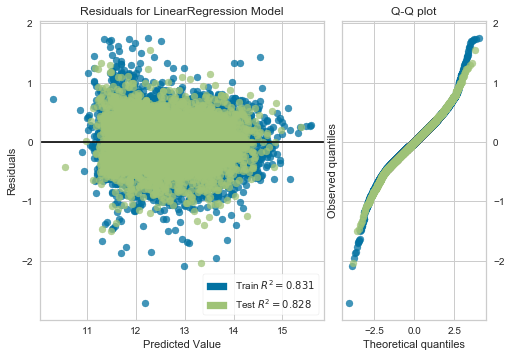

In [34]:
pipeline = make_pipeline(valuation_preprocessor, LinearRegression())
pipeline.fit(X_train, y_train)
visualizer_residuals = ResidualsPlot(pipeline, hist=False, qqplot=True)
visualizer_residuals.fit(X_train, y_train)
visualizer_residuals.score(X_test, y_test)
visualizer_residuals.show();

Residual plot looks great, but the QQ plot could be improved. The basical linear regression model test R-Squared score of 0.829 is very strong to start. How can we improve upon this R-Squared score? 
* There is a degree of multi-colinearity. We can painstakingly review each variable. 
* Introduce regularization to handle multi-colinearity
* Create a more complex or non-linear model

### Regularized models

We will leverage Yellowbrick's AlphaSelection plot to visualize selecting alpha. Under the hood, this visualizer uses cross-validation. Instead of implementing a grid search again, we will use the alpha hyperparameter that the plot finds to plot the residual plot and find the test score.

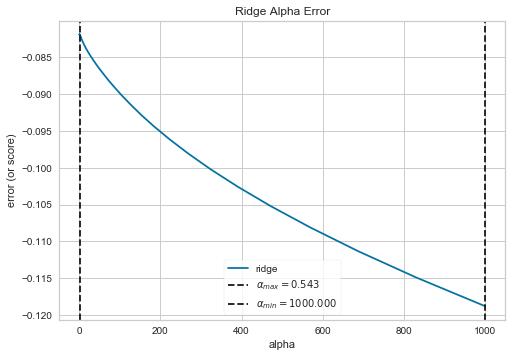

In [35]:
visualizer = ManualAlphaSelection(
    Ridge(),
    alphas=np.logspace(-1, 3, 50),
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=10
)

with parallel_backend('threading', n_jobs=N_JOBS):
    visualizer.fit(valuation_preprocessor.fit_transform(X_train), y_train)

visualizer.show()

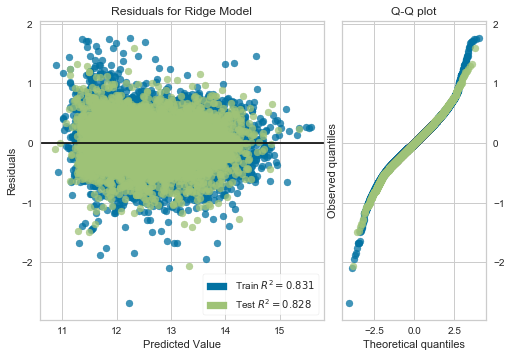

In [36]:
model = Ridge(alpha=0.450)
visualizer_residuals = ResidualsPlot(model, hist=False, qqplot=True)

with parallel_backend('threading', n_jobs=N_JOBS):
    visualizer_residuals.fit(valuation_preprocessor.transform(X_train), y_train)

visualizer_residuals.score(valuation_preprocessor.transform(X_test), y_test)
visualizer_residuals.show();

Surprisingly, regularization did not improve the test score of the model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=7500, test_size=2500, random_state=42)

param_grid = {'lasso__alpha': np.logspace(-5, 3, 25)}

pipeline = make_pipeline(valuation_preprocessor, Lasso())
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')

with parallel_backend('threading', n_jobs=N_JOBS):
    grid_search.fit(X_train, y_train)

visualizer_residuals = ResidualsPlot(grid_search.best_estimator_, hist=False, qqplot=True)
visualizer_residuals.fit(X_train, y_train)
visualizer_residuals.score(X_test, y_test)
visualizer_residuals.show();

Again, no improvement found.

### Polynomial features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2500, test_size=500, random_state=42)

param_grid = {
    'ridge__alpha': np.logspace(-4, 1, 10), # 25),
    'columntransformer__numeric__polynomialfeatures__degree': [2, 3],
}

pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', make_pipeline(StandardScaler(), PolynomialFeatures()), numeric_cols),
        ('categorical', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_cols),
    ]), 
    Ridge()
)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

with parallel_backend('threading', n_jobs=N_JOBS):
    grid_search.fit(X_train, y_train)

visualizer_residuals = ResidualsPlot(grid_search.best_estimator_, hist=False, qqplot=True)
visualizer_residuals.fit(X_train, y_train)
visualizer_residuals.score(X_test, y_test)
visualizer_residuals.show();

Signs of overfitting: high training score, low test score. This is expected, because there are so many features (due to polynomial features), and so little test data.

Next: use Lasso with a high alpha to force features to be selected and minimize the number of polynomial features.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

param_grid = {
    #'columntransformer__numeric__polynomialfeatures__degree': [2, 3],
    #'lasso__alpha': [1, .5, .1, .05, .01, .005, .001, .0005, .0001]
    'lasso__alpha': [.05, .01, .005, .001, .0005, .0001]
}

pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', make_pipeline(StandardScaler(), PolynomialFeatures(3)), numeric_cols),
        ('categorical', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_cols),
    ]), 
    Lasso(alpha=0.001)
)

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

with parallel_backend('threading', n_jobs=N_JOBS):
    #pipeline.fit(X_train, y_train)
    grid_search.fit(X_train, y_train)

#visualizer_residuals = ResidualsPlot(pipeline, hist=False, qqplot=True)
visualizer_residuals = ResidualsPlot(grid_search, hist=False, qqplot=True)
visualizer_residuals.fit(X_train, y_train)
visualizer_residuals.score(X_test, y_test)
visualizer_residuals.show();

### Best valuation model

The 0.829 test R-Square score of the simple linear regression model is nothing to scoff at. The Lasso and Ridge models were not able to produce anything more impressive. The polynomial featurized model is too complex to train, and suffers from overfitting and computational limitations -- there are too many features, and it's a delicate dance between supplying more data to prevent overfitting, and reaching the limitations of computational ability. It is difficult to perform a grid search on this model because training is such a  resource intensive process. An improvement is to find the best model on a small training set, and use a bigger training set on the best parameters.

## Predicting appeals

We will create multiple classifiers, and create multiple hold-out sets in the process. For each classifier, we will use a development test set referred to as `X_test` and `y_test`. We also hold out an additional test data set, `X_test_holdout` and `y_test_holdout`, which will be used to score the performance of the best classifier.

In [ ]:
X = df[categorical_cols + numeric_cols + appeal_cols]
y = df[y_appeal]
X, X_test_holdout, y, y_test_holdout = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)
print(X_train.shape, X_test.shape, X_test_holdout.shape)

We start with a simple classifier - the logistic regression.

In [ ]:
pipeline = make_pipeline(appeals_preprocessor, LogisticRegression())
pipeline.fit(X_train, y_train)
plot_classification_diagnostics(pipeline, X_test, y_test, classes=['No Appeal', 'Appeal'], support=False)

The accuracy is 0.88 -- that's great! But looking more closely at the confusion matrix, notice that when a property is actually appealed, only 0.043 of those appeals are identified. The recall score is abysmal. This is not a good preditor.



### Imbalanced classes

Looking more closely at the distribution of classes, it's apparent why. There is a major class imbalance -- a null classifier could perform just as well.


In [ ]:
class_balance = ClassBalance(labels=['No Appeal', 'Appeal'])
class_balance.fit(y_train)
class_balance.show();

Class imbalance is a problem. It will be harder for a classifier to learn, but there are options to proceed.

* Modify the logistic regression decision boundary so that its predicts the appeal class for a lower probability (the default is 0.50).
* Train different families of classifiers, such as Gaussian, which account for the distribution of classes.
* Train a more complex non-linear classifier, and select recall score as the loss function.
* Rebalance the training dataset with up- and down-sampling techniques. That said, resampling techniques have not been covered in this course.

Also, notice that scikit-learn classifiers have a built-in method for handling class imbalances: the `class_weight` parameter. Using it on a simple logistic regression, the recall score for the appeal class immediately improves: almost 60% of appeals are identified; the trade-off is that the accuracy of the classifier when it predicts a property assessment will be appealed is low: 19.2%. The overall accuracy of the classifier is 67.4% with a weighted F1-score of 29%.

We will see if we can improve upon that.

In [ ]:
pipeline = make_pipeline(appeals_preprocessor, LogisticRegression(class_weight='balanced'))
pipeline.fit(X_train, y_train)
plot_classification_diagnostics(pipeline, X_test, y_test, classes=['No Appeal', 'Appeal'], support=False)

### Decision boundary function

The discrimination threshold plot shows how precision, recall, f1 score, and queue rate change as the discrimination threshold increases. The discrimination threshold is the probability at which you choose the positive class over the negative. For binary classifiers, the threshold is generally set to 50%. Adjusting the discrimination threshold will adjust sensitivity to false positives, which is described by the inverse relationship of precision and recall with respect to the threshold. ("[Discrimination Threshold](https://www.scikit-yb.org/en/latest/api/classifier/threshold.html)," Yellowbrick.)

The visualizer also identifies the ideal discrimination threshold, where the f1 score, the weighted accuracy is maximized, near the inflection points of precision and recall. We will create a modified logistic regression estimator that allows for the discrimination threshold to be adjusted, and train a model with this estimator. 

In [ ]:
pipeline = make_pipeline(appeals_preprocessor, LogisticRegression(multi_class='auto', solver='liblinear'))
visualizer = DiscriminationThreshold(pipeline)
visualizer.fit(X_train, y_train)
visualizer.show();

In [ ]:
class AdjustedLogisticRegression(LogisticRegression):
    def __init__(self, decision_threshold=0.5, penalty='l2', dual=False, tol=0.0001,
                 C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                 random_state=None, solver='lbfgs', max_iter=100, multi_class='auto',
                 verbose=0, warm_start=False, n_jobs=None, l1_ratio=None): 
        super().__init__(penalty=penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept,
                 intercept_scaling=intercept_scaling, class_weight=class_weight,
                 random_state=random_state, solver=solver, max_iter=max_iter,
                 multi_class=multi_class, verbose=verbose, warm_start=warm_start,
                 n_jobs=n_jobs, l1_ratio=l1_ratio)
        self.decision_threshold = decision_threshold

    def predict(self, X):
        return np.where(self.predict_proba(X)[:,1] > self.decision_threshold, 1, 0)

pipeline = make_pipeline(appeals_preprocessor, AdjustedLogisticRegression(decision_threshold=0.17))
pipeline.fit(X_train, y_train)
plot_classification_diagnostics(pipeline, X_test, y_test, classes=['No Appeal', 'Appeal'], support=False)

This model is a marked improvement over our first logistic regression model, and serves as a "happy medium" between the last two models. The overall accuracy of 79.5% is below our plain logit classifier's accuracy of 88%, but the f1 and recall scores are marked improvements: 32.2% over 7.9%, and 43.6% over 4.3% for the appeal class recall. Compared to the previous model, the recall score drops from 60% to 43.6%. Precision for appeal class also increases: when the model classifies an appeal, there is a 25.6% chance that the property will actually be appealed.

We can also go through the same exercise with the class weight-balanced logit model. We will arrive at roughly the same accuracy, f1 and recall scores (give or take some randomness).

### Gaussian Bayes classification

We train a Bayes classifier, implemented with `ComplementNB`, a variant of the Gaussian Naive Bayes classifier that is suited for imbalanced classes. Features are scaled with `MinMaxScaler` because `StandardScaler` will output negative numbers, and the Naive Bayes algorithm requires positive-valued variables. The classifier assumes that the features are normally distributed.

The Gaussian Bayes estimator has hyperparameters that can be tuned. In tuning, we will score each cross-validation fold with weighted-recall score.

In [ ]:
param_grid = {'complementnb__alpha': np.linspace(0, 100, 20)}

pipeline = make_pipeline(
    ColumnTransformer([
      ('numeric', MinMaxScaler(), numeric_cols + appeal_cols),
      ('categorical', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_cols),
    ]),
    ComplementNB(),
)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall_weighted')

with parallel_backend('threading', n_jobs=N_JOBS):
    grid_search.fit(X_train, y_train)

plot_classification_diagnostics(grid_search, X_test, y_test, classes=['No Appeal', 'Appeal'], support=False)

At the currently tuned model, the model improves upon the initial logit model, where recall is improved to 27.7% and accuracy only dips to 81%, but the adjusted discriminant threshold model performs with a better F1 and recall scores and similar overall accuracy. This model will correctly identify a quarter of all property assessments that are appealed, and when an assessment is classified as appealed, there is almost a 1-in-4 chance that the assessment was appealed. This may be a good trade-off, as false positives are minimized.

There is no clarity on how the hyperparameter alpha should be tuned, as it does not converge. At some levels of alpha, the accuracy of the classifier improves upon the linear regression model, but the recall score is not improved. It may be instructive to have a custom loss function that accounts of both recall and precision.

### Support vector classification

Support vector classifiers have a different motivation from from logistic regression and Bayes classifiers, and achieve diferent results. While linear support vector classifiers approach the performance of logistic regression, non-linear SVCs may have improved performance. That said, SVCs are very expensive to train, so we must work with a small sample of training data. It should be noted that due to the high number of features, and small training set size, the models in the cross-validation folds may be too complex and unable to learn enough information.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=7500, test_size=2500, random_state=42)

param_grid = {'linearsvc__C': [1, 10, 100, 1000]}
pipeline = make_pipeline(appeals_preprocessor, LinearSVC(class_weight='balanced'))
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall_macro')

with parallel_backend('threading', n_jobs=N_JOBS):
    grid_search.fit(X_train, y_train)

plot_classification_diagnostics(grid_search.best_estimator_, X_test, y_test, classes=['No Appeal', 'Appeal'], support=True)

The linear model is able to correctly identify 50% of property assessments that will be appealed. When the model does classify an appeal, it is correct 20% of the time. False positives are higher than the Gaussian Bayes model and adjusted discriminant threshold model, and the accuracy at 73% is lower than those two models. This could be due a small training set. As a model, Linear SVC performs worse and is much more expensive and time-consuming to train over the prior two models.

Our attention is turned to non-linear SVC, which may show more promise, but will be hampered by a very limited training set due to how resource-intensive and time-consuming training and cross validation can be for support vector machines. We will search the space for a support vector classifier with a polynomial or gaussian kernel.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1500, test_size=500, random_state=42)

param_grid = [{
    'svc__kernel': ['rbf'],
    'svc__gamma': [1e-3, 1e-4],
    'svc__C': [1, 10, 100, 1000],
}, {
    'svc__kernel': ['poly'],
    'svc__degree': [2, 3],
    'svc__C': [1, 10, 100, 1000],
}]

pipeline = make_pipeline(appeals_preprocessor, SVC(class_weight='balanced'))
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='recall_weighted')

with parallel_backend('threading', n_jobs=N_JOBS):
    grid_search.fit(X_train, y_train)

plot_classification_diagnostics(grid_search.best_estimator_, X_test, y_test, classes=['No Appeal', 'Appeal'], support=True)

In [ ]:
grid_search.best_params_

The non-linear SVC resulted in an intriguing model with the highest accuracy and recall scores of all the models trained, except for the vanilla logit model, which could not recall the appeal class. Additionally, the f1 score is just behind the best model, and the recall and precision are very acceptable: the classifier will correctly classify over a quarter of assessments that are appealed, and when the model classifies an appeal, it is correct 30% of the time. False positives are minimal. This model is a good candidate to try on a larger training set.

### Resampling classes
Finally, we can try to balance our classes. This technique was not covered in the course. SMOTE is a technique to resample the classes and create a form of separation so that the classes can be more easily separated. Here, we will just plug in random values.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pipeline = ImbalancePipeline([
    ('preprocess', appeals_preprocessor),
    ('sampler', SMOTE(random_state=42)),
])
X_up, y_up = pipeline.fit_resample(X_train, y_train)

class_balance = ClassBalance(labels=['No Appeal', 'Appeal'])
class_balance.fit(y_up)
class_balance.show();

With classes resampled, the model can train on classes with similar distribution.

In [ ]:
pipeline = ImbalancePipeline([
    ('preprocess', appeals_preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', LogisticRegression())
])
pipeline.fit(X_train, y_train)

plot_classification_diagnostics(pipeline, X_test, y_test, classes=['No Appeal', 'Appeal'], support=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=7500, test_size=2500, random_state=42)

pipeline = ImbalancePipeline([
    ('preprocess', appeals_preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('svc', SVC(C=10, kernel='poly', degree=3))
])

with parallel_backend('threading', n_jobs=N_JOBS):
    pipeline.fit(X_train, y_train)

plot_classification_diagnostics(pipeline, X_test, y_test, classes=['No Appeal', 'Appeal'], support=True)

### Best classifier

We are selecting a model by 'feeling' rather than a systematic model selection -- though that is a challenge that has not been thoroughly addressed in the course. It 'feels' like the SVC model with the polynomial kernel performed the best. We will now score that model using a larger dataset -- not the full holdout test dataset because it's an expensive training. The hyperparameters of the model are tuned to the best parameters found by the SVC classifier above. The same pipeline is not used because the variable was overwritten. Otherwise, it would be as simple as the following:

```
grid_search.fit(X, y)
grid_search.score(X_test_holdout, y_test_holdout)
```

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=7500, test_size=2500, random_state=42)

pipeline = make_pipeline(appeals_preprocessor, SVC(C=10, kernel='poly', degree=3, class_weight='balanced'))

with parallel_backend('threading', n_jobs=10):
  pipeline.fit(X, y)

plot_classification_diagnostics(pipeline, X_test_holdout, y_test_holdout, classes=['No Appeal', 'Appeal'], support=True)

The result of this model with more data is interesting. The overall accuracy score of the model has fallen from 88% to 80.8%, but the F1 score increased from 28.6% to 31%, beating the F1 score and accuracy of our prior models. The recall of  the appeal class improved to 43%, but the precision of the appeal class dropped from 30% to 24.1%. Still, the model classifies almost half of properties that are appealed, and of the properties that it classifies as appealed, the error rate is 75.9%. The error rate is smaller than other model. This model is very similar to the modified logit model with a custom discriminant threshold. Knowing that, it is not worth to maintain an SVC classifier, as it is much more expensive to train.

## Next steps

We can think of a lot of ways to improve our processes and models.

* Using dimensionality reduction techniques to reduce the feature space and reduce multi-colinearity. For example, using principal components analysis to reduce many related features, for example, Census features such as race, college, median household income and average school score, which happen to have moderate multi-colinearity. Reducing the feature space will open a path to create simpler models, or leverage complex, non-linear modeling techniques; to reduce variance caused by multi-colinearity, and to reduce computation resources.
* Otherwise, investing time to moving development to a cluster so that grid search can be spread across many compute nodes. Training non-linear models for the regression model required a lot of computational resources that personal laptop were not capable of handling.
* Barring that, a more nuanced and manual approach to feature selection by analyzing individual features and their inreractions. This will be challenging due to the limited information available in the data dictionary. 
* Exploring the development and implementation of a symmetrical loss function for regression model.
* Clarity on whether CCAO values sensitivity or specificity in detecting appeals. This would give a better approach for modeling appeals and building a better classifier and cost funciton. Perhaps a custom score function can be developed that accounts for the recall of the minority class.
* Automate method to systematically compare different types of models (e.g., SVC to Bayes to LinearRegression)
* Compare the models in this project to the deployed CCAO projects.